***Dog Breed Classification***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import partial

In [9]:
df = pd.read_csv('dog-breed-identification/labels.csv')
print(df.head())
print(df.shape)


                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
(10222, 2)


(-0.5, 119.5, 0.0, 132.3)

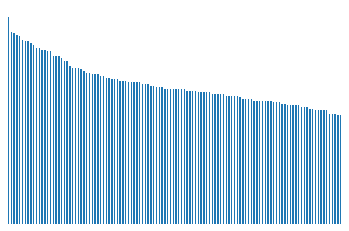

In [10]:
df['breed'].value_counts().plot.bar()
df['filepath'] = 'train/' + df['id'] + '.jpg'
plt.axis('off')

In [11]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [13]:
features = df['filepath']
target = df['breed']

X_train, X_test, Y_train, Y_test = train_test_split(
                                        features,
                                        target,
                                        test_size = .2,
                                        random_state = 0)

X_train.shape, X_test.shape

((8177,), (2045,))

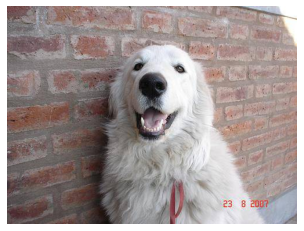

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image = load_img('dog-breed-identification/train/0a0c223352985ec154fd604d7ddceabd.jpg')
image = img_to_array(image).astype(int)
data = np.expand_dims(image, 0)
plt.axis('off')
plt.imshow(data[0])

In [4]:
def default_datagen():
  datagen = ImageDataGenerator(featurewise_center=True,rotation_range=(0-30),width_shift_range=0.2,
                             height_shift_range=0.2,brightness_range=[0.5,1.5],
                             shear_range=0.2, zoom_range=0.2,channel_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True,fill_mode='nearest')
  return datagen

In [5]:
def plot_augmentation(datagen, data, n_rows=1, n_cols=5):
    n_images = n_rows * n_cols
    gen_flow = datagen.flow(data)
    plt.figure(figsize=(n_cols*4, n_rows*3))
    for image_index in range(n_images):
        image = next(gen_flow)
        plt.subplot(n_rows, n_cols, image_index+1)
        plt.axis('off')
        plt.imshow(image[0], vmin=0, vmax=255)


C:\Users\mgiorgio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


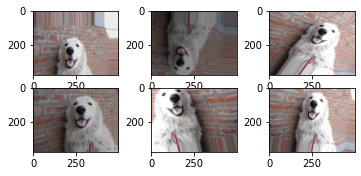

In [15]:
datagen = default_datagen()
it = datagen.flow(data, batch_size=2)
# plot_augmentation(datagen, data)
for i in range(6):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = next(it)
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)

In [16]:
def aug_img():
    return 

In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)

In [18]:
for layer in pre_trained_model.layers: 
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7') 
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape) 
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


In [19]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.AUC()]
)